# Семинар. Генеративно состязательные сети.

Plan:
* Vanilla GAN in 1D coding.
  * Mode collapse.
  * Non-saturating GAN.
* WGANs on multimodal 2D data.
  * **Theory**: Wasserstein distance. Wasserstein GAN (WGAN).
* WGAN with gradient penalty (WGAN-GP).

## I Часть. Vanilla GAN для 1D распределения.

### Библиотеки

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Датасет

#### 1D простые распределения

##### 1D GMM: 2 Gaussians

Мы используем **смесь двух гауссовых распределений** (на английском такое распределение называют Gaussian Mixture Model, GMM):

$$
p_{\text{data}}(x) = \frac{1}{2} \cdot \mathcal{N}(x \mid \mu_1 = -2,\, \sigma_1^2 = 0.5^2) + \frac{1}{2} \cdot \mathcal{N}(x \mid \mu_2 = 2,\, \sigma_2^2 = 0.5^2)
$$

Общая формула плотности вероятности **одномерного (унимодального) гауссовского (нормального) распределения** с параметрами  
- среднее значение (математическое ожидание) $\mu \in \mathbb{R} $,  
- дисперсия $ \sigma^2 > 0 $ (стандартное отклонение $ \sigma > 0 $)  

выглядит следующим образом:

$$
\mathcal{N}(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\!\left( -\frac{(x - \mu)^2}{2\sigma^2} \right)
$$


Распишем PDF (Probability Density Function) для смеси двух гауссиан, которые мы задали выше:

$$
p_{\text{data}}(x) = \frac{1}{2} \cdot \frac{1}{\sqrt{2\pi (0.5)^2}} \exp\left( -\frac{(x + 2)^2}{2 \cdot (0.5)^2} \right) + \frac{1}{2} \cdot \frac{1}{\sqrt{2\pi (0.5)^2}} \exp\left( -\frac{(x - 2)^2}{2 \cdot (0.5)^2} \right)
$$

Упростим:

$$
p_{\text{data}}(x) = \frac{1}{\sqrt{2\pi \cdot 0.25}} \left[ \frac{1}{2} e^{-2(x + 2)^2} + \frac{1}{2} e^{-2(x - 2)^2} \right]
= \frac{1}{\sqrt{\pi/2}} \left[ \frac{1}{2} e^{-2(x + 2)^2} + \frac{1}{2} e^{-2(x - 2)^2} \right] = \frac{1}{\sqrt{2\pi}} \left[ e^{-2(x + 2)^2} + e^{-2(x - 2)^2} \right]
$$

Это распределение имеет **две четкие моды** при $x = -2$ и $x = 2$, что делает его идеальным для демонстрации **mode collapse**.

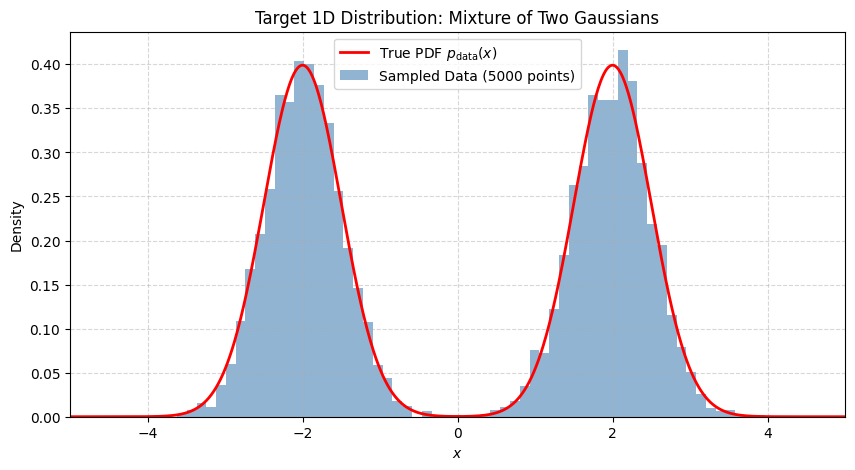

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define the true PDF
def p_data(x):

    norm_const = 1.0 / np.sqrt(2.0 * np.pi)
    return norm_const * np.exp(-2 * (x + 2)**2) + \
           norm_const * np.exp(-2 * (x - 2)**2)

# Sample real data
def sample_real_data(n_samples=1000):
    # 50% from N(-2, 0.5^2), 50% from N(2, 0.5^2)
    n1 = n_samples // 2
    n2 = n_samples - n1
    x1 = np.random.normal(-2, 0.5, n1)
    x2 = np.random.normal(2, 0.5, n2)
    return np.concatenate([x1, x2])


np.random.seed(42)
n_samples = 5000
real_samples = sample_real_data(n_samples)

# Plot
x_grid = np.linspace(-5, 5, 1000)
plt.figure(figsize=(10, 5))
plt.plot(x_grid, p_data(x_grid), 'r-', lw=2, label='True PDF $p_{\\text{data}}(x)$')
plt.hist(real_samples, bins=60, density=True, alpha=0.6, color='steelblue', label='Sampled Data (5000 points)')
plt.xlabel('$x$')
plt.ylabel('Density')
plt.title('Target 1D Distribution: Mixture of Two Gaussians')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(-5, 5)
plt.show()

##### 1D GMM: 3 Gaussians

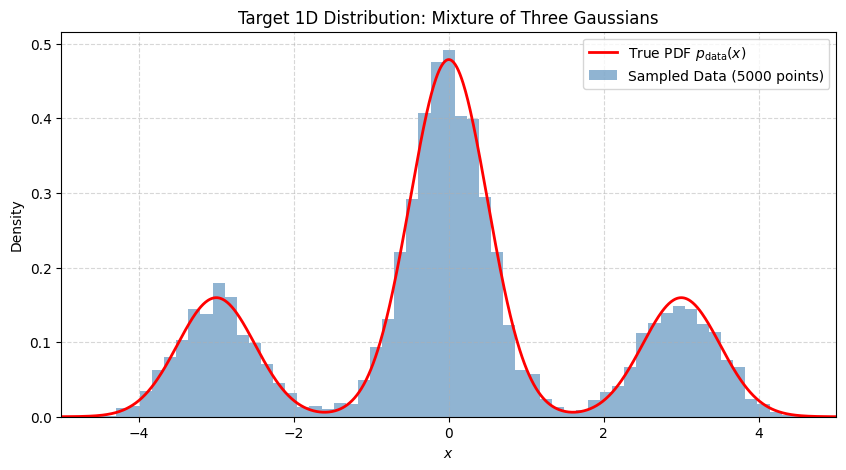

In [ ]:
# --- Целевое распределение ---
def target_pdf(x):
    return (0.2 * norm.pdf(x, -3, 0.5) +
            0.6 * norm.pdf(x, 0, 0.5) +
            0.2 * norm.pdf(x, 3, 0.5))

def sample_target(n):
    # Сэмплируем с учётом весов
    weights = [0.2, 0.6, 0.2]
    means = [-3, 0, 3]
    stds = [0.5, 0.5, 0.5]

    choices = np.random.choice(len(weights), size=n, p=weights)
    samples = []
    for c in choices:
        samples.append(np.random.normal(means[c], stds[c]))
    return np.array(samples)

np.random.seed(42)
n_samples = 5000
real_samples = sample_target(n_samples)

# Plot
x_grid = np.linspace(-5, 5, 1000)
plt.figure(figsize=(10, 5))
plt.plot(x_grid, target_pdf(x_grid), 'r-', lw=2, label='True PDF $p_{\\text{data}}(x)$')
plt.hist(real_samples, bins=60, density=True, alpha=0.6, color='steelblue', label='Sampled Data (5000 points)')
plt.xlabel('$x$')
plt.ylabel('Density')
plt.title('Target 1D Distribution: Mixture of Three Gaussians')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(-5, 5)
plt.show()

#### 2D простые распределения

##### 2D GMM: flower - 8 Gaussians

Пусть:
- $ K = 8 $ — число мод,
- Радиус круга: $ R $,
- Стандартное отклонение каждой моды: $ \sigma $,
- Все моды имеют равный вес: $ \pi_k = \frac{1}{8} $.

Тогда плотность вероятности:

$$
p_{\text{flower}}(x, y) = \frac{1}{8} \sum_{k=0}^{7} \frac{1}{2\pi\sigma^2} \exp\left( -\frac{(x - \mu_{k,x})^2 + (y - \mu_{k,y})^2}{2\sigma^2} \right)
$$

где $\mu_{k,x} = R \cos\left(\frac{2\pi k}{8}\right), \quad
\mu_{k,y} = R \sin\left(\frac{2\pi k}{8}\right)
$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_flower_gmm(n_samples, n_modes=8, radius=3.0, std=0.3, seed=None):
    """
    Генерирует выборку из GMM с n_modes гауссианами по кругу (без центра).
    Все моды — равновероятны.
    """
    if seed is not None:
        np.random.seed(seed)

    angles = np.linspace(0, 2 * np.pi, n_modes, endpoint=False)
    centers = np.stack([radius * np.cos(angles), radius * np.sin(angles)], axis=1)  # (8, 2)

    # Равновероятный выбор моды
    mode_indices = np.random.choice(n_modes, size=n_samples)
    noise = np.random.normal(scale=std, size=(n_samples, 2))
    samples = centers[mode_indices] + noise

    return samples.astype(np.float32)

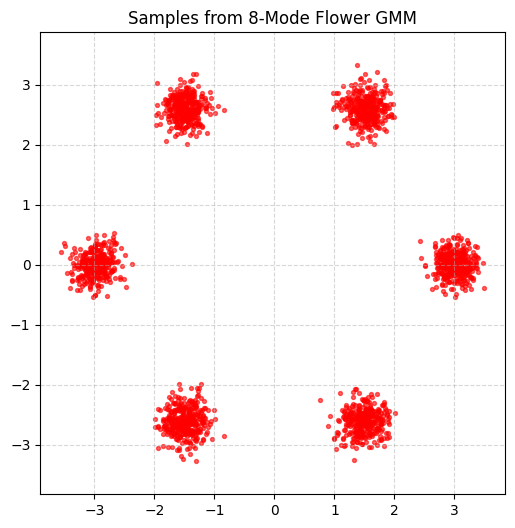

In [ ]:
# Сэмплы
real_samples = sample_flower_gmm(2000, n_modes=6, radius=3.0, std=0.2, seed=42)

plt.figure(figsize=(6, 6))
plt.scatter(real_samples[:, 0], real_samples[:, 1], s=8, alpha=0.6, c='red')
plt.title('Samples from 8-Mode Flower GMM')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

/tmp/ipython-input-2201204782.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


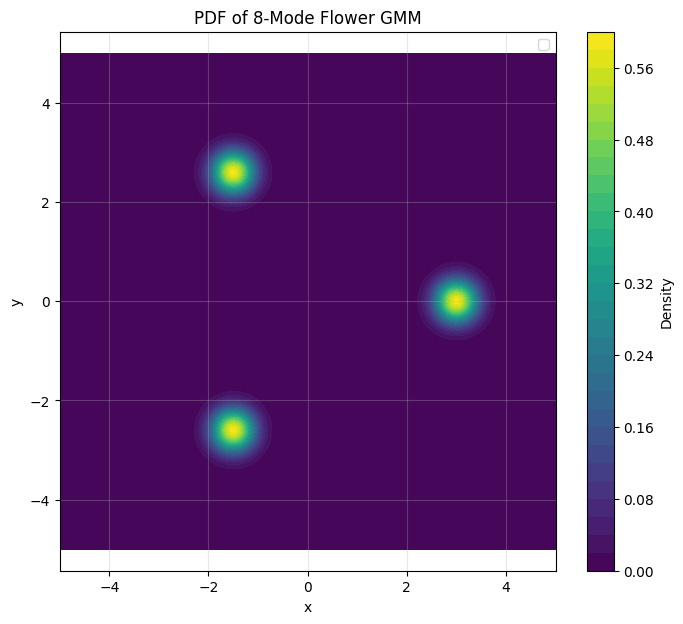

In [ ]:
def flower_gmm_pdf(x, y, n_modes=8, radius=3.0, std=0.3):
    """Вычисляет плотность 8-модовой GMM в точке (x, y)."""
    angles = np.linspace(0, 2 * np.pi, n_modes, endpoint=False)
    mu_x = radius * np.cos(angles)
    mu_y = radius * np.sin(angles)

    pdf = np.zeros_like(x)
    coeff = 1.0 / (2 * np.pi * std**2)
    weight = 1.0 / n_modes

    for mx, my in zip(mu_x, mu_y):
        exponent = -((x - mx)**2 + (y - my)**2) / (2 * std**2)
        pdf += weight * coeff * np.exp(exponent)

    return pdf

# Сетка для визуализации
x = np.linspace(-5, 5, 300)
y = np.linspace(-5, 5, 300)
X, Y = np.meshgrid(x, y)
Z = flower_gmm_pdf(X, Y, n_modes=3, radius=3.0, std=0.3)

# Heatmap
plt.figure(figsize=(8, 7))
plt.contourf(X, Y, Z, levels=30, cmap='viridis')
plt.colorbar(label='Density')
# Отметим центры мод
angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
centers_x = 3.0 * np.cos(angles)
centers_y = 3.0 * np.sin(angles)
# plt.scatter(centers_x, centers_y, c='red', s=50, edgecolors='white', label='Mode Centers')
plt.title('PDF of 8-Mode Flower GMM')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Модель: Vanilla GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim=2, output_dim=2, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)  # выход: (x, y)
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

### Лосс

#### Vanilla GAN Loss

Лосс **Vanilla GAN** (в оригинальной формулировке Goodfellow et al., 2014) задаётся как **минимакс-игра** между генератором $ G $ и дискриминатором $ D $:

$$
\min_G \max_D \mathcal{L}_{\text{Vanilla}}(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

Где:
- $ p_{\text{data}}(x) $ — распределение реальных данных,
- $ p_z(z) $ — априорное распределение латентного вектора (обычно $ \mathcal{N}(0, I) $ или $ \mathcal{U}[-1,1] $),
- $ D(x) \in (0,1) $ — выход дискриминатора (вероятность того, что $ x $ реален),
- $ G(z) $ — сгенерированный объект.



❗**Практическая реализация лоссов:**

- **Лосс дискриминатора** (максимизируется в теории, но на практике **минимизируется отрицательный лосс**):

$$
\mathcal{L}_D = -\mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] - \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

- **Лосс генератора** в «наивной» (saturating) форме (который приводит к затуханию градиентов):

$$
\mathcal{L}_G^{\text{saturating}} = -\mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$





Однако из-за **исчезающих градиентов** эту формулу **не используют на практике**.

Вместо этого применяют **non-saturating** версию (тоже предложенную в той же статье как альтернатива):

$$
\mathcal{L}_G^{\text{non-sat}} = -\mathbb{E}_{z \sim p_z}[\log D(G(z))]
$$

Эта форма даёт более стабильные градиенты, когда дискриминатор становится сильным.

Давайте разберемся с лоссом дискриминатора.

В оригинальной статье дискриминатор обучается максимизировать следующую функцию:

$$
\mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

Интерпретация:
- Для **реальных данных** $x$: максимизировать $\log D(x)$ → т.е. сделать $D(x) \to 1$
- Для **фейковых данных** $G(z)$: максимизировать $\log(1 - D(G(z)))$ → т.е. сделать $D(G(z)) \to 0$

Это **в точности задача бинарной классификации**:
- Метка реальных данных: **1**
- Метка сгенерированных данных: **0**

Для одного примера с истинной меткой $y \in \{0,1\}$ и предсказанием модели $p \in (0,1)$, BCE определяется как:

$$
\text{BCE}(y, p) = -\big[ y \log(p) + (1 - y) \log(1 - p) \big]
$$

Теперь применим это к нашему случаю:

Для реального образца $(y = 1)$:
$$
\text{BCE}(1, D(x)) = -\big[ 1 \cdot \log(D(x)) + 0 \cdot \log(1 - D(x)) \big] = -\log(D(x))
$$

→ Чтобы **минимизировать** BCE, нужно **максимизировать** $\log D(x)$ → **то, что нужно!**

Для фейкового образца $(y = 0)$:
$$
\text{BCE}(0, D(G(z))) = -\big[ 0 \cdot \log(D(G(z))) + 1 \cdot \log(1 - D(G(z))) \big] = -\log(1 - D(G(z)))
$$

→ Минимизация BCE ↔ максимизация $\log(1 - D(G(z)))$ → **тоже то, что нужно!**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SaturatingGeneratorLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, D_fake):
        target = torch.zeros_like(D_fake)
        return F.binary_cross_entropy(D_fake, target)

class NonsaturatingGeneratorLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, D_fake):
        target = torch.ones_like(D_fake)
        return F.binary_cross_entropy(D_fake, target)

class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, D_real, D_fake):
        real_loss = F.binary_cross_entropy(D_real, torch.ones_like(D_real))  # = -log(D_real)
        fake_loss = F.binary_cross_entropy(D_fake, torch.zeros_like(D_fake)) # = -log(1 - D_fake)
        return real_loss + fake_loss

### Тренировка

#### 2D Training

Saturating Loss

In [ ]:
import torch.optim as optim

# ===== CONFIG =====
USE_SATURATING = True  # ← Set to False for non-saturating
device = 'cuda'
batch_size = 16
n_epochs = 5000

# Data
real_data = sample_flower_gmm(2000, n_modes=6, radius=3.0, std=0.2, seed=42)
real_data_tensor = torch.tensor(real_data)

# Models
G = Generator(input_dim=2, output_dim=2, hidden_dim=16).to(device)
D = Discriminator(input_dim=2, hidden_dim=16).to(device)

# Losses
disc_loss_fn = DiscriminatorLoss()
if USE_SATURATING:
    gen_loss_fn = SaturatingGeneratorLoss()
else:
    gen_loss_fn = NonsaturatingGeneratorLoss()

# Optimizers
optimizerG = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))

# Training
d_losses, g_losses = [], []

for epoch in range(n_epochs):
    # Real data batch
    idx = torch.randint(0, len(real_data_tensor), (batch_size,))
    x_real = real_data_tensor[idx].to(device)

    # Generate fake data
    z = torch.randn(batch_size, 2).to(device)
    x_fake = G(z)

    # --- Train Discriminator ---
    D.zero_grad()
    D_real = D(x_real)
    D_fake = D(x_fake.detach())  # Detach to avoid backprop through G
    d_loss = disc_loss_fn(D_real, D_fake)
    d_loss.backward()
    optimizerD.step()

    # --- Train Generator ---
    G.zero_grad()
    D_fake_for_G = D(x_fake)
    g_loss = gen_loss_fn(D_fake_for_G)
    g_loss.backward()
    optimizerG.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if epoch % 1000 == 0:
        print(f"[Epoch {epoch}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

[Epoch 0] D_loss: 1.2724, G_loss: 0.7332
[Epoch 1000] D_loss: 0.0449, G_loss: 0.0333
[Epoch 2000] D_loss: 0.0087, G_loss: 0.0057
[Epoch 3000] D_loss: 0.0026, G_loss: 0.0020
[Epoch 4000] D_loss: 0.0011, G_loss: 0.0008


### Визуализируем результаты

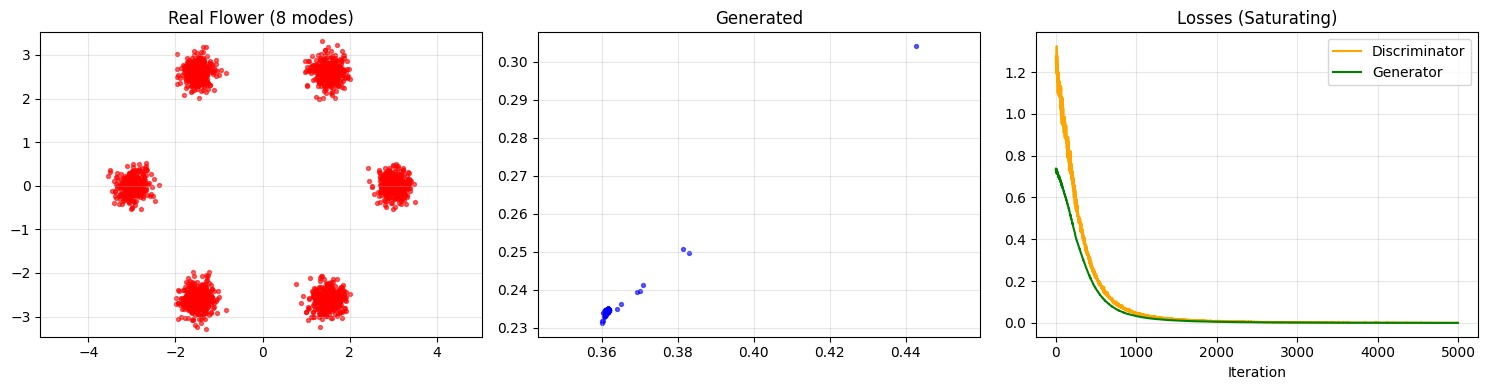

In [ ]:
import matplotlib.pyplot as plt

G.eval()
with torch.no_grad():
    z_test = torch.randn(2000, 2).to(device)
    fake_data = G(z_test).cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Real
axes[0].scatter(real_data[:, 0], real_data[:, 1], s=8, alpha=0.6, c='red')
axes[0].set_title('Real Flower (8 modes)')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Generated
axes[1].scatter(fake_data[:, 0], fake_data[:, 1], s=8, alpha=0.6, c='blue')
axes[1].set_title('Generated')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

# Losses
axes[2].plot(d_losses, label='Discriminator', color='orange')
axes[2].plot(g_losses, label='Generator', color='green')
axes[2].set_title(f'Losses ({ "Saturating" if USE_SATURATING else "Non-saturating" })')
axes[2].set_xlabel('Iteration')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Итак, мы видим:
* проблему Vanishing gradients

Non-saturating Loss

In [ ]:
import torch.optim as optim

# ===== CONFIG =====
USE_SATURATING = False  # ← Set to False for non-saturating
device = 'cuda'
batch_size = 16
n_epochs = 5000

# Data
real_data = sample_flower_gmm(2000, n_modes=6, radius=3.0, std=0.2, seed=42)
real_data_tensor = torch.tensor(real_data)

# Models
G = Generator(input_dim=2, output_dim=2, hidden_dim=128).to(device)
D = Discriminator(input_dim=2, hidden_dim=128).to(device)

# Losses
disc_loss_fn = DiscriminatorLoss()
if USE_SATURATING:
    gen_loss_fn = SaturatingGeneratorLoss()
else:
    gen_loss_fn = NonsaturatingGeneratorLoss()

# Optimizers
optimizerG = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))

# Training
d_losses, g_losses = [], []

for epoch in range(n_epochs):
    # Real data batch
    idx = torch.randint(0, len(real_data_tensor), (batch_size,))
    x_real = real_data_tensor[idx].to(device)

    # Generate fake data
    z = torch.randn(batch_size, 2).to(device)
    x_fake = G(z)

    # --- Train Discriminator ---
    D.zero_grad()
    D_real = D(x_real)
    D_fake = D(x_fake.detach())  # Detach to avoid backprop through G
    d_loss = disc_loss_fn(D_real, D_fake)
    d_loss.backward()
    optimizerD.step()

    # --- Train Generator ---
    G.zero_grad()
    D_fake_for_G = D(x_fake)
    g_loss = gen_loss_fn(D_fake_for_G)
    g_loss.backward()
    optimizerG.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if epoch % 1000 == 0:
        print(f"[Epoch {epoch}] D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")

[Epoch 0] D_loss: 1.3721, G_loss: 0.7268
[Epoch 1000] D_loss: 1.2147, G_loss: 0.9928
[Epoch 2000] D_loss: 1.1331, G_loss: 0.9354
[Epoch 3000] D_loss: 1.2399, G_loss: 0.9180
[Epoch 4000] D_loss: 1.3354, G_loss: 0.7475


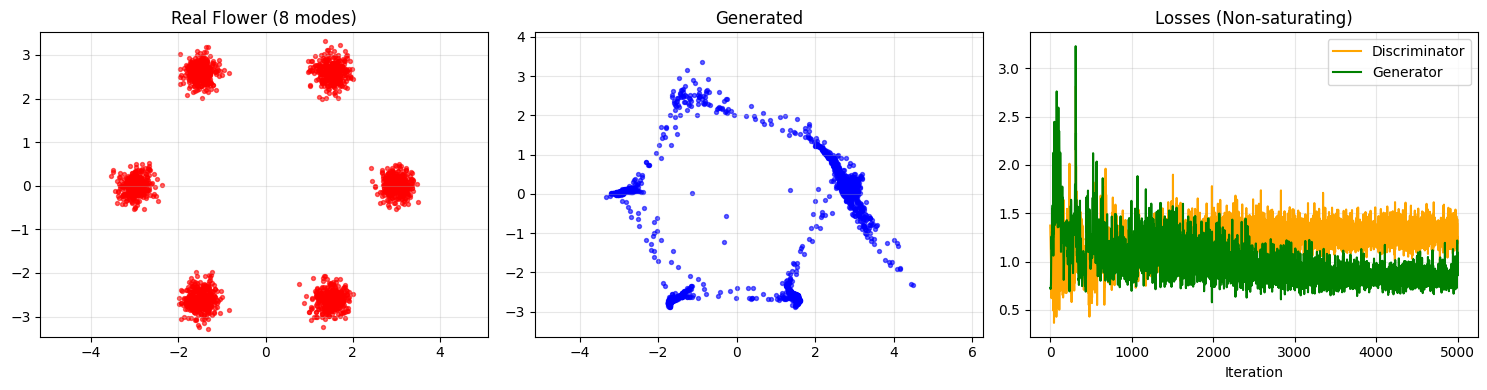

In [ ]:
import matplotlib.pyplot as plt

G.eval()
with torch.no_grad():
    z_test = torch.randn(2000, 2).to(device)
    fake_data = G(z_test).cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Real
axes[0].scatter(real_data[:, 0], real_data[:, 1], s=8, alpha=0.6, c='red')
axes[0].set_title('Real Flower (8 modes)')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Generated
axes[1].scatter(fake_data[:, 0], fake_data[:, 1], s=8, alpha=0.6, c='blue')
axes[1].set_title('Generated')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

# Losses
axes[2].plot(d_losses, label='Discriminator', color='orange')
axes[2].plot(g_losses, label='Generator', color='green')
axes[2].set_title(f'Losses ({ "Saturating" if USE_SATURATING else "Non-saturating" })')
axes[2].set_xlabel('Iteration')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Итак, мы видим:
* странные генерации
* mode collapse
* Теряются некоторые части распределения

## II Часть. WGAN.

**WGAN (Wasserstein GAN)** и **WGAN-GP** (с градиентным штрафом) решают ключевые проблемы Vanilla GAN:

* нестабильность обучения,
* отсутствие корреляции между лоссом и качеством генерации,
* mode collapse.



WGAN предлагает радикально новый подход, заменяя JS дивергенцию на **Earth Mover's Distance (EMD)** или, более формально, **Расстояние Вассерштейна**.

Для функции потерь WGAN используется **Канторович-Рубинштейн двойственная форма** расстояния Вассерштейна:

$$ \max_{D \in 1-Lipschitz} [ \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)] - \mathbb{E}_{\tilde{x} \sim \mathbb{P}_g}[D(\tilde{x})] ] $$

Где:
*   $ D $ – "критик" (аналог дискриминатора).
*   $ \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)] $ – средний отклик критика на реальных данных.
*   $ \mathbb{E}_{\tilde{x} \sim \mathbb{P}_g}[D(\tilde{x})] $ – средний отклик критика на сгенерированных данных.
*   $ D \in 1-Lipschitz $ – ключевое ограничение: функция $ D $ должна быть **1-Липшицевой**.

#### Что такое Липшицево ограничение?

Функция является 1-Липшицевой, если скорость ее изменения ограничена. Грубо говоря, градиент этой функции не должен превышать 1 по модулю ни в одной точке.
$ |D(x_1) - D(x_2)| \leq |x_1 - x_2| $

Это ограничение не позволяет критику становиться "слишком хорошим" и дает осмысленные градиенты для обучения генератора даже когда распределения далеки друг от друга.

Чтобы обеспечить Липшицево ограничение, авторы оригинального WGAN предложили **weight clipping** (ограничение весов):

*   После каждого обновления весов критика, все его параметры "обрезаются" до небольшого фиксированного диапазона $ [-c, c] $(например, $ c = 0.01 $).

**Изменения в алгоритме по сравнению с обычным GAN:**

1.  **Убрали сигмоиду с выхода критика**. Критик теперь выдает произвольное число (score), а не вероятность. Это называется **Critic**, а не Discriminator.
2.  **Функция потерь** становится простой и интерпретируемой.
    *   Потери Критика: $ L_{critic} = D(\tilde{x}) - D(x) $(минимизировать)
    *   Потери Генератора: $ L_{generator} = -D(\tilde{x}) $ (минимизировать)
3.  **Применяем weight clipping** к весам критика.
4.  **Рекомендуется обучать Критика несколько раз на каждую итерацию Генератора** (например, 5 раз), чтобы лучше аппроксимировать расстояние Вассерштейна.








### Датасет

In [ ]:
# Генерируем данные
real_data = sample_flower_gmm(2000, n_modes=2, radius=3.0, std=0.3, seed=42)
real_data_tensor = torch.tensor(real_data)

### Модель: WGAN

Важно для WGAN:

* Нет Sigmoid на выходе критика!
* Нет BatchNorm в критике (или будьте осторожны) — но для простоты оставим LeakyReLU.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=2, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):  # Называем "Critic", а не Discriminator
    def __init__(self, input_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
            # ← НЕТ Sigmoid! Выход — вещественное число
        )
    def forward(self, x):
        return self.net(x)

### Тренировка

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Переносим данные на устройство
real_data_tensor = real_data_tensor.to(device)

# Модели
G = Generator(latent_dim=2, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

# Инициализация весов (рекомендована в WGAN)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

G.apply(weights_init)
C.apply(weights_init)

# Оптимизаторы: WGAN использует RMSprop (не Adam!)
lr = 5e-5  # Маленький lr
optimizerG = optim.RMSprop(G.parameters(), lr=lr)
optimizerC = optim.RMSprop(C.parameters(), lr=lr)

# Параметры WGAN
n_critic = 5        # Обновляем критик 5 раз на 1 обновление генератора
clip_value = 0.01   # Границы для weight clipping
batch_size = 128
n_epochs = 5000

Using device: cuda


In [ ]:
c_losses = []  # Лосс критика (Wasserstein distance estimate)
g_losses = []  # Лосс генератора

for epoch in range(n_epochs):
    for _ in range(n_critic):
        # --- Обновление критика ---
        C.zero_grad()

        # Реальные данные
        idx = torch.randint(0, len(real_data_tensor), (batch_size,))
        real_samples = real_data_tensor[idx]

        # Фейковые данные
        z = torch.randn(batch_size, 2, device=device)
        fake_samples = G(z).detach()  # .detach() — не обновляем G

        # Оценки критика
        real_validity = C(real_samples)
        fake_validity = C(fake_samples)

        # Wasserstein loss для критика: maximize E[C(real)] - E[C(fake)]
        # → минимизируем отрицание
        c_loss = -(torch.mean(real_validity) - torch.mean(fake_validity))
        c_loss.backward()
        optimizerC.step()

        # Weight clipping
        for p in C.parameters():
            p.data.clamp_(-clip_value, clip_value)

    # --- Обновление генератора ---
    G.zero_grad()
    z = torch.randn(batch_size, 2, device=device)
    fake_samples = G(z)
    fake_validity = C(fake_samples)

    # Генератор максимизирует E[C(fake)] → минимизируем -E[C(fake)]
    g_loss = -torch.mean(fake_validity)
    g_loss.backward()
    optimizerG.step()

    c_losses.append(c_loss.item())
    g_losses.append(g_loss.item())

    if epoch % 1000 == 0:
        w_distance = -c_loss.item()  # Оценка Wasserstein расстояния
        print(f"[Epoch {epoch}] W-distance: {w_distance:.4f}, G_loss: {g_loss.item():.4f}")

[Epoch 0] W-distance: 0.0001, G_loss: 0.0000
[Epoch 1000] W-distance: 0.0021, G_loss: -0.0041
[Epoch 2000] W-distance: 0.0012, G_loss: -0.0054
[Epoch 3000] W-distance: 0.0003, G_loss: -0.0064
[Epoch 4000] W-distance: 0.0001, G_loss: -0.0063


### Визуализируем результат

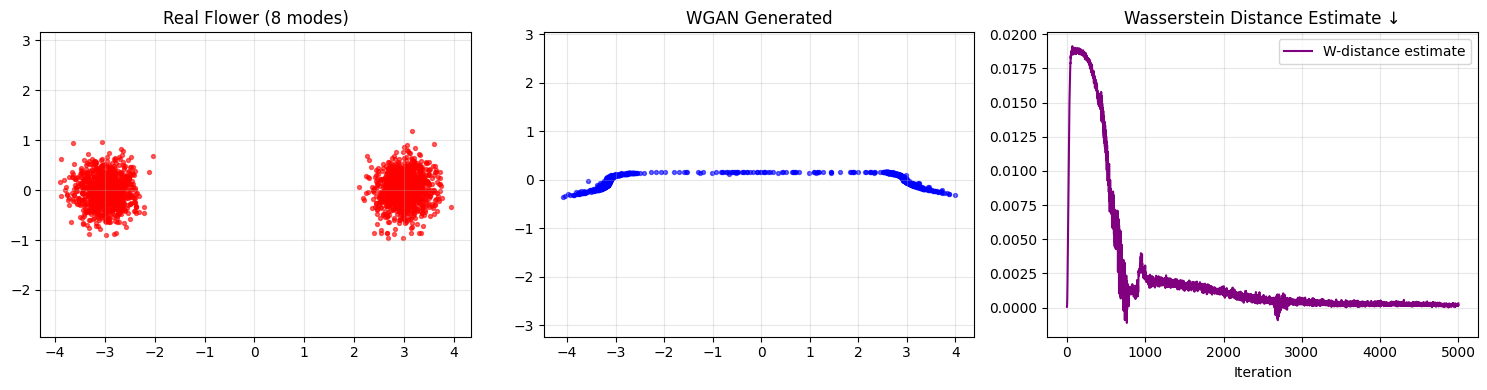

In [ ]:
# Сгенерировать финальные образцы
G.eval()
with torch.no_grad():
    z_test = torch.randn(2000, 2, device=device)
    fake_data = G(z_test).cpu().numpy()

# Построить
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Реальное распределение
axes[0].scatter(real_data[:, 0], real_data[:, 1], s=8, alpha=0.6, c='red')
axes[0].set_title('Real Flower (8 modes)')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Сгенерированное
axes[1].scatter(fake_data[:, 0], fake_data[:, 1], s=8, alpha=0.6, c='blue')
axes[1].set_title('WGAN Generated')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

# Wasserstein оценка (отрицательный лосс критика)
w_estimates = [-x for x in c_losses]
axes[2].plot(w_estimates, color='purple', label='W-distance estimate')
axes[2].set_title('Wasserstein Distance Estimate ↓')
axes[2].set_xlabel('Iteration')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Преимущества WGAN:

*   **Стабильность обучения**: Меньше зависимость от архитектуры сети и гиперпараметров.
*   **Осмысленная метрика потерь**: Значение потерь критика коррелирует с качеством генерации. Если оно уменьшается, качество растет. Это позволяет объективно сравнивать модели.
*   **Отсутствие коллапса моды**: На практике WGAN гораздо реже страдает от этой проблемы.

## III Часть. WGAN-GP

Недостатки WGAN (Weight Clipping):

*   **Weight clipping – грубый способ обеспечения Липшицева ограничения.**
*   Он может привести к тому, что веса критика "прилипнут" к граничным значениям $ -c $ или $ c $, что сильно ограничивает его емкость и способность к обучению.
*   Это может вызывать "артефакты обрезания" в генерируемых образцах и все еще не идеальную стабильность.


> WGAN-GP – решает проблему weight clipping'а.



Вместо грубого обрезания весов, WGAN-GP **напрямую накладывает Липшицево ограничение**, добавляя специальный член в функцию потерь критика, который штрафует за отклонение нормы градиента от 1.

$$ L_{critic} = \underbrace{\mathbb{E}_{\tilde{x} \sim \mathbb{P}_g}[D(\tilde{x})] - \mathbb{E}_{x \sim \mathbb{P}_r}[D(x)]}_{\text{Original WGAN loss}} + \underbrace{\lambda \ \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}}[( \lVert \nabla_{\hat{x}} D(\hat{x}) \rVert_2 - 1 )^2]}_{\text{Gradient Penalty}} $$

Где:
*   $ \lambda $ – коэффициент штрафа (обычно 10).
*   $ \hat{x} $ – точки, полученные путем **линейной интерполяции** между реальными и сгенерированными данными: $ \hat{x} = \epsilon x + (1 - \epsilon) \tilde{x} $, где $ \epsilon \sim U[0, 1] $.


### Датасет

In [ ]:
real_data = sample_flower_gmm(2000, n_modes=8, radius=3.0, std=0.3, seed=42)
real_data_tensor = torch.tensor(real_data)

### Модель

 В WGAN-GP не требуется weight clipping, поэтому можно использовать более выразительные архитектуры.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=2, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):
    def __init__(self, input_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
            # ← НЕТ Sigmoid! Выход — скаляр в R
        )
    def forward(self, x):
        return self.net(x)

### Gradient Penalty (ядро WGAN-GP)

In [ ]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    """Вычисляет градиентный штраф из статьи WGAN-GP."""
    # 1. Случайная интерполяция между реальными и фейковыми
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # 2. Пропускаем через критик
    d_interpolates = critic(interpolates)

    # 3. Градиент выхода по интерполированным входам
    fake = torch.ones(d_interpolates.size(), device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # 4. Норма градиентов
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

### Тренировка

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
real_data_tensor = real_data_tensor.to(device)

G = Generator(latent_dim=2, output_dim=2).to(device)
C = Critic(input_dim=2).to(device)

# Инициализация весов
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

G.apply(weights_init)
C.apply(weights_init)

# WGAN-GP использует Adam!
optimizerG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizerC = optim.Adam(C.parameters(), lr=1e-4, betas=(0.5, 0.9))

# Гиперпараметры
n_critic = 5          # Критик обучается 5 раз за 1 шаг генератора
lambda_gp = 10        # Вес градиентного штрафа
batch_size = 128
n_epochs = 5000

In [ ]:
c_losses = []
g_losses = []

for epoch in range(n_epochs):
    for _ in range(n_critic):
        C.zero_grad()

        # Реальные и фейковые данные
        idx = torch.randint(0, len(real_data_tensor), (batch_size,))
        real_samples = real_data_tensor[idx]
        z = torch.randn(batch_size, 2, device=device)
        fake_samples = G(z).detach()

        # Оценки критика
        real_validity = C(real_samples)
        fake_validity = C(fake_samples)

        # Градиентный штраф
        gradient_penalty = compute_gradient_penalty(C, real_samples, fake_samples, device)

        # Лосс критика
        c_loss = -(torch.mean(real_validity) - torch.mean(fake_validity)) + lambda_gp * gradient_penalty
        c_loss.backward()
        optimizerC.step()

    # Обучение генератора
    G.zero_grad()
    z = torch.randn(batch_size, 2, device=device)
    fake_samples = G(z)
    fake_validity = C(fake_samples)
    g_loss = -torch.mean(fake_validity)
    g_loss.backward()
    optimizerG.step()

    c_losses.append(c_loss.item())
    g_losses.append(g_loss.item())

    if epoch % 1000 == 0:
        w_distance = -c_loss.item() + lambda_gp * gradient_penalty.item()
        print(f"[Epoch {epoch}] W-distance est.: {w_distance:.4f}, GP: {gradient_penalty.item():.4f}")

[Epoch 0] W-distance est.: 0.0028, GP: 0.9976
[Epoch 1000] W-distance est.: 2.3454, GP: 0.0177
[Epoch 2000] W-distance est.: 0.7738, GP: 0.0196
[Epoch 3000] W-distance est.: 0.3308, GP: 0.0086
[Epoch 4000] W-distance est.: 0.4168, GP: 0.0291


### Визуализация

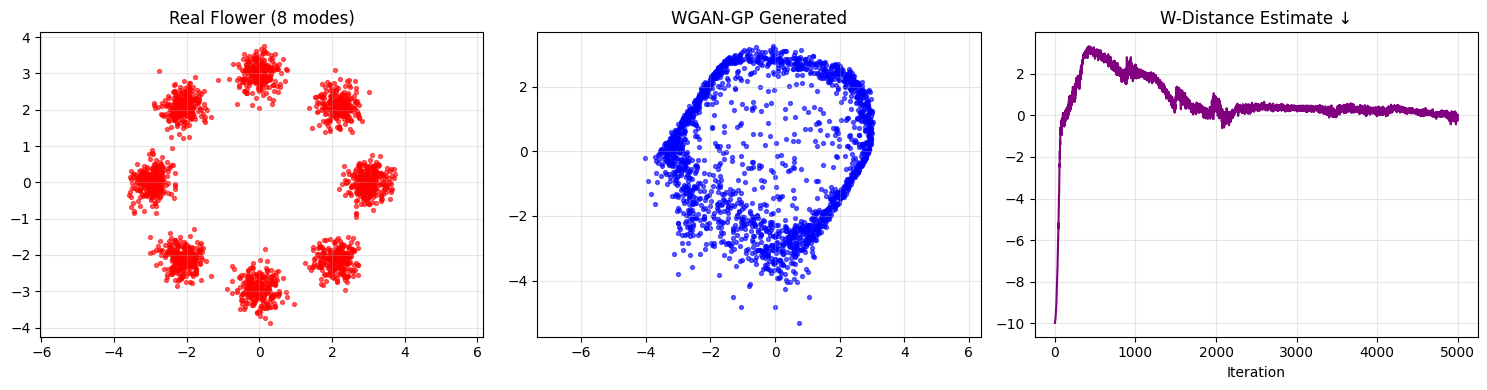

In [ ]:
G.eval()
with torch.no_grad():
    z_test = torch.randn(2000, 2, device=device)
    fake_data = G(z_test).cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Реальное распределение
axes[0].scatter(real_data[:, 0], real_data[:, 1], s=8, alpha=0.6, c='red')
axes[0].set_title('Real Flower (8 modes)')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Сгенерированное
axes[1].scatter(fake_data[:, 0], fake_data[:, 1], s=8, alpha=0.6, c='blue')
axes[1].set_title('WGAN-GP Generated')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.3)

# Wasserstein estimate
w_estimates = [-x for x in c_losses]
axes[2].plot(w_estimates, color='purple')
axes[2].set_title('W-Distance Estimate ↓')
axes[2].set_xlabel('Iteration')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()